# Tutorial para ejecutar la red neuronal tras una nueva vela OHLC

In [1]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [2]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Done!


In [3]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_M30.csv')  


#### Carga datos históricos de csv y Red neuronal

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.10.01  00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1  2001.10.01  01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2  2001.10.01  02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3  2001.10.01  03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4  2001.10.01  04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-10-01 00:00:00  0.9103  0.9112  0.9100  0.9107      108    0      50
1 2001-10-01 01:00:00  0.9107  0.9109  0.9098  0.9105      202    0      50
2 2001-10-01 02:00:00  0.9106  0.9109  0.9059  0.9076      441    0      50
3 2001-10-01 03:00:00  0.9078  0.9107  0.9073  0.9095      376    0      50
4 2001-10-01 04:00:00  0.9094  0.9106  0.9088  0.9101      275    0      50 
--------------------------
                    

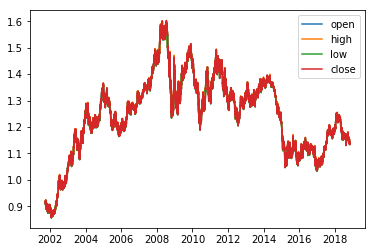

In [4]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1_now.csv',sep=';', reindex_fillna=True, plot_it=True)    

# visualizo una sección
trace = go.Candlestick(x=df.index[-100:],
                               open=df.OPEN[-100:],
                               high=df.HIGH[-100:],
                               low=df.LOW[-100:],
                               close=df.CLOSE[-100:])
data = [trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=700,    
    title='Mostrando últimos 100 datos',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [5]:
####################################################################################
# PASO 13: Elije el archivo del que recuperar los pesos del modelo entrenado
file_weights = "model_weights_3010003.hdf5"

In [6]:
####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def reload_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
batch_size = 64
model = reload_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


NameError: name 'num_inputs' is not defined

#### Este paso es la simulación de recepción de una nueva vela en 'new_bar'

In [64]:
# Preparo DataFrame para simular ejecución. Quito la última entrada y la dejo como nueva vela
new_bar = df.iloc[-1]
df = df[:-1]
print('df shape:', df.shape, 'df last bar: ', df.iloc[-1], ' new_bar: ',new_bar)

df shape: (155568, 7) df last bar:  OPEN          1.16093
HIGH          1.16123
LOW           1.16016
CLOSE         1.16030
TICKVOL    3909.00000
VOL           0.00000
SPREAD        4.00000
Name: 2018-09-30 23:00:00, dtype: float64  new_bar:  OPEN          1.16173
HIGH          1.16173
LOW           1.16064
CLOSE         1.16105
TICKVOL    1438.00000
VOL           0.00000
SPREAD       53.00000
Name: 2018-10-01 00:00:00, dtype: float64


#### Añado la vela a mi dataframe

In [65]:
# añado la nueva vela al final del dataframe actual 'dfcurr' y me quedo con los M últimos datos
print(df.tail(),'\r\n---------------------')
df = df.append(new_bar, ignore_index = True)
df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
# elimina los valores nulos y los rellena con el valor anterior
df.fillna(method='ffill', inplace =True)
print(df.tail(),'\r\n---------------------')


                        OPEN     HIGH      LOW   CLOSE  TICKVOL  VOL  SPREAD
2018-09-30 19:00:00  1.16093  1.16123  1.16016  1.1603   3909.0  0.0     4.0
2018-09-30 20:00:00  1.16093  1.16123  1.16016  1.1603   3909.0  0.0     4.0
2018-09-30 21:00:00  1.16093  1.16123  1.16016  1.1603   3909.0  0.0     4.0
2018-09-30 22:00:00  1.16093  1.16123  1.16016  1.1603   3909.0  0.0     4.0
2018-09-30 23:00:00  1.16093  1.16123  1.16016  1.1603   3909.0  0.0     4.0 
---------------------
                        OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  SPREAD
2018-09-30 20:00:00  1.16093  1.16123  1.16016  1.16030   3909.0  0.0     4.0
2018-09-30 21:00:00  1.16093  1.16123  1.16016  1.16030   3909.0  0.0     4.0
2018-09-30 22:00:00  1.16093  1.16123  1.16016  1.16030   3909.0  0.0     4.0
2018-09-30 23:00:00  1.16093  1.16123  1.16016  1.16030   3909.0  0.0     4.0
2018-10-01 00:00:00  1.16173  1.16173  1.16064  1.16105   1438.0  0.0    53.0 
---------------------


#### Las siguientes celdas son la preparación de los datos para la red neuronal

In [66]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, applied, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    cols = list()
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        sma8 = talib.SMA(df[p], timeperiod=8)
        sma50 = talib.SMA(df[p], timeperiod=50)
        sma100 = talib.SMA(df[p], timeperiod=100)    
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                sma8_50 = ((sma8/sma50)-1)/np.mean(bollinger_width)
                sma50_100 = ((sma50/sma100)-1)/np.mean(bollinger_width)
                df[i+'_'+p] = sma8_50 + sma50_100
                cols.append(i+'_'+p)
              
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))
    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df.dropna(inplace=True)    
    df = df[cols]
    if plot_it:
        plt.figure(figsize=(12,12))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(df[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    return df

####################################################################################
####################################################################################

dfapp = add_indicators(df, ['HIGH','LOW'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True, plot_it=False, starts=df.shape[0]-2000, plot_len=2000)
dfapp



(155422, 10) 
--------


,bollWidthRel_HIGH,bollR_HIGH,atr_HIGH,SMAx3_HIGH,bollWidthRel_LOW,bollR_LOW,atr_LOW,SMAx3_LOW,HIGH,LOW
2001-01-05 03:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.95510,0.95320
2001-01-05 04:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.95530,0.95320
2001-01-05 05:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.95800,0.95410
2001-01-05 06:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.95750,0.95490
2001-01-05 07:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.95710,0.95380
2001-01-05 08:00:00,0.206753,0.961478,0.001829,1.471819,0.218952,0.745753,-0.001079,1.430208,0.95960,0.95310
2001-01-05 09:00:00,0.205207,0.770090,0.001621,1.496445,0.207278,0.736528,-0.001300,1.433392,0.95700,0.95330
2001-01-05 10:00:00,0.194876,0.631325,0.001564,1.495891,0.199102,0.690457,-0.001307,1.428322,0.95510,0.95290
2001-01-05 11:00:00,0.185549,0.599802,0.001614,1.474818,0.188398,0.618838,-0.001293,1.394844,0.95490,0.95210
2001-01-05 12:00:00,0.174253,0.594611,0.001686,1.453626,0.169683,0.576786,-0.001343,1.357079,0.95510,0.95180


In [94]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df_in.shift(i))
    names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 18
forecast_wdow = 6
num_outputs = 2
num_inputs = dfapp.shape[1] - num_outputs
sts_df = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, forecast_wdow, False)

# las salidas t+n tendrán datos NaN ya que aún no hay datos para ellas, por lo tanto , las pondremos a 0
#sts_df.fillna(0, inplace=True)
sts_df

,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,HIGH(t+1),LOW(t+1),HIGH(t+2),LOW(t+2),HIGH(t+3),LOW(t+3),HIGH(t+4),LOW(t+4),HIGH(t+5),LOW(t+5)
2001-01-05 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95530,0.95320,0.95800,0.95410,0.95750,0.95490,0.95710,0.95380,0.95960,0.95310
2001-01-05 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95800,0.95410,0.95750,0.95490,0.95710,0.95380,0.95960,0.95310,0.95700,0.95330
2001-01-05 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95750,0.95490,0.95710,0.95380,0.95960,0.95310,0.95700,0.95330,0.95510,0.95290
2001-01-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95710,0.95380,0.95960,0.95310,0.95700,0.95330,0.95510,0.95290,0.95490,0.95210
2001-01-05 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95960,0.95310,0.95700,0.95330,0.95510,0.95290,0.95490,0.95210,0.95510,0.95180
2001-01-05 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95700,0.95330,0.95510,0.95290,0.95490,0.95210,0.95510,0.95180,0.95480,0.95140
2001-01-05 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95510,0.95290,0.95490,0.95210,0.95510,0.95180,0.95480,0.95140,0.95560,0.94630
2001-01-05 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95490,0.95210,0.95510,0.95180,0.95480,0.95140,0.95560,0.94630,0.95500,0.94850
2001-01-05 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95510,0.95180,0.95480,0.95140,0.95560,0.94630,0.95500,0.94850,0.95380,0.95040
2001-01-05 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.95480,0.95140,0.95560,0.94630,0.95500,0.94850,0.95380,0.95040,0.95390,0.95120


In [95]:
# reescribo todas las salidas con los valores del step (t) ya que no se utilizan en la predicción, pero son necesarios
# datos coherentes para realizar la normalización
# Después descarto los NaN

for i in range(len(sts_df.columns)-(num_outputs * (forecast_wdow-1)),len(sts_df.columns)):
    sts_df[sts_df.columns[i]] = sts_df[sts_df.columns[i-num_outputs]]
sts_df.dropna(inplace=True)
sts_df

replace col= HIGH(t+1) with col= HIGH(t)
replace col= LOW(t+1) with col= LOW(t)
replace col= HIGH(t+2) with col= HIGH(t+1)
replace col= LOW(t+2) with col= LOW(t+1)
replace col= HIGH(t+3) with col= HIGH(t+2)
replace col= LOW(t+3) with col= LOW(t+2)
replace col= HIGH(t+4) with col= HIGH(t+3)
replace col= LOW(t+4) with col= LOW(t+3)
replace col= HIGH(t+5) with col= HIGH(t+4)
replace col= LOW(t+5) with col= LOW(t+4)


,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,HIGH(t+1),LOW(t+1),HIGH(t+2),LOW(t+2),HIGH(t+3),LOW(t+3),HIGH(t+4),LOW(t+4),HIGH(t+5),LOW(t+5)
2001-01-05 21:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.146593,0.918537,...,0.95850,0.95720,0.95850,0.95720,0.95850,0.95720,0.95850,0.95720,0.95850,0.95720
2001-01-05 22:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.168122,1.041759,...,0.95880,0.95740,0.95880,0.95740,0.95880,0.95740,0.95880,0.95740,0.95880,0.95740
2001-01-05 23:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.178544,0.937468,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 00:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.189038,0.866987,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 01:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.206753,0.961478,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 02:00:00,0.206753,0.961478,0.001829,1.471819,0.218952,0.745753,-0.001079,1.430208,0.205207,0.770090,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 03:00:00,0.205207,0.770090,0.001621,1.496445,0.207278,0.736528,-0.001300,1.433392,0.194876,0.631325,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 04:00:00,0.194876,0.631325,0.001564,1.495891,0.199102,0.690457,-0.001307,1.428322,0.185549,0.599802,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 05:00:00,0.185549,0.599802,0.001614,1.474818,0.188398,0.618838,-0.001293,1.394844,0.174253,0.594611,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550
2001-01-06 06:00:00,0.174253,0.594611,0.001686,1.453626,0.169683,0.576786,-0.001343,1.357079,0.142388,0.545868,...,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550,0.95840,0.95550


In [96]:
####################################################################################
# PASO 6: Crea columnas con salidas en función de valores de salida (t, t+n), con opción de borrar las salidas anteriores
def build_min_max_cols(df, **kwargs):
    df = df.copy()
    cols = list()
    drop_cols = False
    for key,val in kwargs.items():
        if key=='drop': 
            drop_cols=val
            continue
        if key=='cols_min':
            cols = val            
            df['min'] = df[cols].apply(lambda x: np.min(x), axis=1)
            continue
        if key=='cols_max':
            cols = val                    
            df['max'] = df[cols].apply(lambda x: np.max(x), axis=1)
            continue
    if drop_cols:
        df = df.drop(columns=cols_min+cols_max)
    return df

####################################################################################
####################################################################################

sts_src = build_min_max_cols(sts_df, cols_min=['LOW(t)','LOW(t+1)','LOW(t+2)','LOW(t+3)','LOW(t+4)','LOW(t+5)'], cols_max=['HIGH(t)','HIGH(t+1)','HIGH(t+2)','HIGH(t+3)','HIGH(t+4)','HIGH(t+5)'], drop=False)
print(sts_src.head())
# sts_src contiene el dataframe original sin escalado y con todas las columnas más representativas


                     bollWidthRel_HIGH(t-18)  bollR_HIGH(t-18)  \
2001-01-05 21:00:00                 0.152275          0.932599   
2001-01-05 22:00:00                 0.146593          0.918537   
2001-01-05 23:00:00                 0.168122          1.041759   
2001-01-06 00:00:00                 0.178544          0.937468   
2001-01-06 01:00:00                 0.189038          0.866987   

                     atr_HIGH(t-18)  SMAx3_HIGH(t-18)  bollWidthRel_LOW(t-18)  \
2001-01-05 21:00:00        0.001521          1.064631                0.243077   
2001-01-05 22:00:00        0.001614          1.110881                0.188026   
2001-01-05 23:00:00        0.001764          1.217782                0.197474   
2001-01-06 00:00:00        0.001750          1.321879                0.209365   
2001-01-06 01:00:00        0.001807          1.398634                0.216810   

                     bollR_LOW(t-18)  atr_LOW(t-18)  SMAx3_LOW(t-18)  \
2001-01-05 21:00:00         0.883228      -0

In [97]:
####################################################################################
# PASO 8: Selecciono las columnas que se utilizarán en la red neuronal (para normalizarse)
sts_df = sts_src.copy()
sts_df.drop(columns=['HIGH(t)','HIGH(t+1)','HIGH(t+2)','HIGH(t+3)','HIGH(t+4)','HIGH(t+5)','LOW(t)','LOW(t+1)','LOW(t+2)','LOW(t+3)','LOW(t+4)','LOW(t+5)'], inplace=True)
num_outputs = 2
num_out_steps = 1
sts_df.head()

,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,bollWidthRel_HIGH(t-1),bollR_HIGH(t-1),atr_HIGH(t-1),SMAx3_HIGH(t-1),bollWidthRel_LOW(t-1),bollR_LOW(t-1),atr_LOW(t-1),SMAx3_LOW(t-1),min,max
2001-01-05 21:00:00,0.152275,0.932599,0.001521,1.064631,0.243077,0.883228,-0.001407,1.095325,0.146593,0.918537,...,0.082687,0.822300,0.001807,1.148793,0.110590,0.956448,-0.002271,0.978040,0.9572,0.9585
2001-01-05 22:00:00,0.146593,0.918537,0.001614,1.110881,0.188026,0.921875,-0.001243,1.157961,0.168122,1.041759,...,0.085726,0.856584,0.001786,1.189753,0.124485,0.987752,-0.002150,1.057196,0.9574,0.9588
2001-01-05 23:00:00,0.168122,1.041759,0.001764,1.217782,0.197474,0.925536,-0.001114,1.241985,0.178544,0.937468,...,0.087930,0.860352,0.001486,1.218568,0.137735,0.940902,-0.002086,1.224106,0.9555,0.9584
2001-01-06 00:00:00,0.178544,0.937468,0.001750,1.321879,0.209365,0.918466,-0.000993,1.331837,0.189038,0.866987,...,0.090778,0.771910,0.001543,1.254206,0.143449,0.739540,-0.001971,1.322654,0.9555,0.9584
2001-01-06 01:00:00,0.189038,0.866987,0.001807,1.398634,0.216810,0.813846,-0.001000,1.405814,0.206753,0.961478,...,0.093724,0.746247,0.001550,1.310545,0.149489,0.723822,-0.002014,1.389059,0.9555,0.9584


In [98]:
####################################################################################
# PASO 9: Creo los scalers de cada columna seleccionada
values = sts_df.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=values, columns=sts_df.columns, index=sts_df.index)
sts_values = sts_scaled.values
sts_scaled.head()


,bollWidthRel_HIGH(t-18),bollR_HIGH(t-18),atr_HIGH(t-18),SMAx3_HIGH(t-18),bollWidthRel_LOW(t-18),bollR_LOW(t-18),atr_LOW(t-18),SMAx3_LOW(t-18),bollWidthRel_HIGH(t-17),bollR_HIGH(t-17),...,bollWidthRel_HIGH(t-1),bollR_HIGH(t-1),atr_HIGH(t-1),SMAx3_HIGH(t-1),bollWidthRel_LOW(t-1),bollR_LOW(t-1),atr_LOW(t-1),SMAx3_LOW(t-1),min,max
2001-01-05 21:00:00,-0.981727,0.397491,-0.576205,-0.026875,-0.970698,0.351674,0.687408,0.045742,-0.982409,0.384614,...,-0.990078,0.296489,-0.518309,-0.011103,-0.986669,0.418866,0.525492,0.023850,-0.679309,-0.682002
2001-01-05 22:00:00,-0.982409,0.384614,-0.557389,-0.018207,-0.977334,0.387139,0.718185,0.057433,-0.979825,0.497451,...,-0.989713,0.327883,-0.522652,-0.003427,-0.984994,0.447592,0.548240,0.038625,-0.678786,-0.681220
2001-01-05 23:00:00,-0.979825,0.497451,-0.526994,0.001826,-0.976195,0.390499,0.742272,0.073116,-0.978575,0.401949,...,-0.989448,0.331333,-0.583442,0.001973,-0.983396,0.404599,0.560284,0.069779,-0.683756,-0.682262
2001-01-06 00:00:00,-0.978575,0.401949,-0.529889,0.021334,-0.974761,0.384011,0.765021,0.089887,-0.977315,0.337409,...,-0.989107,0.250345,-0.571863,0.008652,-0.982708,0.219818,0.581694,0.088173,-0.683756,-0.682262
2001-01-06 01:00:00,-0.977315,0.337409,-0.518309,0.035719,-0.973864,0.288005,0.763683,0.103696,-0.975190,0.423936,...,-0.988753,0.226846,-0.570415,0.019210,-0.981979,0.205393,0.573665,0.100568,-0.683756,-0.682262


In [117]:
# obtengo la última muestra que será la próxima a validar
validation = sts_scaled[-1:].values
validation = validation.astype('float32')
num_validation_samples = 1
# obtengo los pares x-y de validación
x_validation, y_validation = validation[0,:-(num_outputs * num_out_steps)], validation[0,-(num_outputs * num_out_steps):]
x_validation = x_validation.reshape((1, num_in_steps, num_inputs))
y_validation = y_validation.reshape(1,num_outputs * num_out_steps)
print('X Validation shape:', x_validation.shape, ' Y Validation shape:', y_validation.shape, '\r\n')


X Validation shape: (1, 18, 8)  Y Validation shape: (1, 2) 



#### Ejecuta la Red neuronal con la última vela recibida

In [132]:
# realiza la predicción
import math
x = x_validation
y = y_validation
predictions = model.predict(x, batch_size=1,verbose=0)

# deshago el scaling
xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
xy_values = scaler.inverse_transform(xy_values)

xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
xyhat_values = scaler.inverse_transform(xyhat_values)

# Calculo el error RMSE
rmse_val = math.sqrt(sk.mean_squared_error(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
print('RMSE: %f' % rmse_val)




RMSE: 0.146045


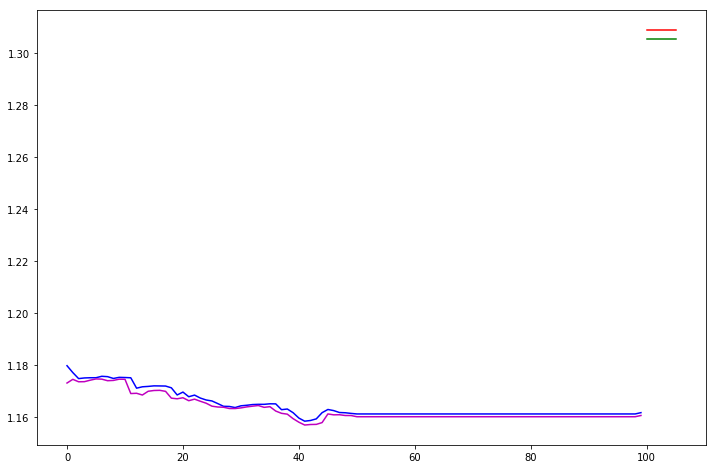

In [139]:
# visualizo la predicción: para ello:

# Primero visualizo los datos de entrada: tomo "al menos" los últimos num_in_steps valores del dataframe dfapp: HIGH y LOW
samples = max(100, num_in_steps)
plt.figure(figsize=(12,8))
plt.plot(dfapp['HIGH'][-samples:].values,color='b')
plt.plot(dfapp['LOW'][-samples:].values,color='m')
# A continuación visualizo la predicción, como dos rayas (roja-verde) del tamaño especificado en forecast_wdow
yhat_min = np.ones(forecast_wdow) * xyhat_values[0,-(num_outputs * num_out_steps)]
yhat_max = np.ones(forecast_wdow) * xyhat_values[0,-(num_outputs * num_out_steps)+1]
plt.plot(np.arange(samples, samples+forecast_wdow), yhat_max,color='r')
plt.plot(np.arange(samples, samples+forecast_wdow), yhat_min,color='g')